In [26]:
import numpy as np
import tensorflow as tf
from scipy.optimize import linprog
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

# Generate synthetic data for demonstration
num_embeddings = 1000
embedding_dim = 128
batch_size = 32
num_batches = 100

In [28]:
frequencies = np.random.zipf(2, num_embeddings)  # Zipf's law for skewed distribution
frequencies = frequencies / np.sum(frequencies)  # Normalize frequencies

# Generate random embedding table
embedding_table = np.random.randn(num_embeddings, embedding_dim).astype(np.float32)

In [11]:
embedding_table

array([[-0.8096035 ,  0.42406103, -0.47383934, ..., -0.76272476,
        -0.7691423 , -0.9399031 ],
       [ 0.82947487, -0.19382614, -0.26451483, ..., -1.4675252 ,
         0.16476084,  0.0508877 ],
       [ 0.17334166,  0.2439532 , -0.22320226, ...,  0.3196518 ,
        -0.50417984, -0.08152267],
       ...,
       [-0.49309   ,  0.25385582,  0.592243  , ...,  0.6755974 ,
        -0.01592341,  0.20500964],
       [-0.68571943, -0.59505117,  0.71489984, ...,  1.2784437 ,
        -1.4234252 ,  0.2894248 ],
       [ 0.9834146 , -1.1221254 , -0.8219745 , ..., -0.692645  ,
        -1.0381238 , -0.51417375]], dtype=float32)

In [29]:
batch_indices = [np.random.choice(num_embeddings, size=batch_size, p=frequencies) for _ in range(num_batches)]

In [30]:
def simulate_memory_access(batch_indices, embedding_table, hbm_capacity, dram_capacity, hbm=None):
    hbm_access = 0
    dram_access = 0
    if hbm is None:
        hbm = np.zeros(num_embeddings, dtype=bool)

    for batch in batch_indices:
        for idx in batch:
            if not hbm[idx]:
                if np.sum(hbm) * embedding_dim < hbm_capacity:
                    hbm[idx] = True
                    hbm_access += 1
                else:
                    dram_access += 1
            else:
                hbm_access += 1

    return hbm_access, dram_access

# Initial memory access without optimization
hbm_capacity = 512 * 1024 * 1024  # 512 MB
dram_capacity = 16 * 1024 * 1024 * 1024  # 16 GB

hbm_access, dram_access = simulate_memory_access(batch_indices, embedding_table, hbm_capacity, dram_capacity)
print(f"Initial HBM Access: {hbm_access}, DRAM Access: {dram_access}")

Initial HBM Access: 3200, DRAM Access: 0


In [32]:
# RecShard: Memory optimization for single-node systems
def recshard(frequencies, embedding_dim, hbm_capacity, dram_capacity):
    # Convert capacities to number of embeddings
    hbm_capacity = hbm_capacity // embedding_dim
    dram_capacity = dram_capacity // embedding_dim

    # Ensure total capacity is sufficient
    if hbm_capacity + dram_capacity < num_embeddings:
        raise ValueError("Total capacity (HBM + DRAM) is insufficient to hold all embeddings.")

    # Define the optimization problem
    c = -frequencies  # Minimize the negative of frequencies to maximize them
    A_eq = [np.ones(num_embeddings)]
    b_eq = [hbm_capacity + dram_capacity]
    bounds = [(0, 1) for _ in range(num_embeddings)]

    # Solve the linear programming problem
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if res.success:
        # Assign embeddings to HBM and DRAM
        hbm = res.x > 0.5
        drams = res.x <= 0.5
    else:
        # Heuristic approach if LP fails
        sorted_indices = np.argsort(-frequencies)
        hbm = np.zeros(num_embeddings, dtype=bool)
        for i in sorted_indices:
            if np.sum(hbm) < hbm_capacity:
                hbm[i] = True
        drams = np.logical_not(hbm)

    return hbm, drams

# Apply RecShard
try:
    hbm, drams = recshard(frequencies, embedding_dim, hbm_capacity, dram_capacity)
except ValueError as e:
    print(e)
    hbm = np.zeros(num_embeddings, dtype=bool)  # Fallback to no optimization

# Simulate memory access with RecShard
hbm_access, dram_access = simulate_memory_access(batch_indices, embedding_table, hbm_capacity, dram_capacity, hbm=hbm)
print(f"RecShard HBM Access: {hbm_access}, DRAM Access: {dram_access}")


RecShard HBM Access: 3200, DRAM Access: 0


In [33]:
# FlexShard: Memory optimization for multi-node systems
def flexshard(frequencies, embedding_dim, hbm_capacity, dram_capacity, num_nodes):
    # Convert capacities to number of embeddings
    hbm_capacity = hbm_capacity // embedding_dim
    dram_capacity = dram_capacity // embedding_dim

    # Ensure total capacity is sufficient
    if hbm_capacity + dram_capacity < num_embeddings:
        raise ValueError("Total capacity (HBM + DRAM) is insufficient to hold all embeddings.")

    # Define the optimization problem
    c = -frequencies  # Minimize the negative of frequencies to maximize them
    A_eq = [np.ones(num_embeddings)]
    b_eq = [hbm_capacity + dram_capacity]
    bounds = [(0, 1) for _ in range(num_embeddings)]

    # Solve the linear programming problem
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

    if res.success:
        # Assign embeddings to nodes
        node_assignments = np.zeros(num_embeddings, dtype=int)
        node_loads = np.zeros(num_nodes)

        for i in range(num_embeddings):
            if res.x[i] > 0.5:
                node_assignments[i] = np.argmin(node_loads)
                node_loads[node_assignments[i]] += 1
    else:
        # Heuristic approach if LP fails
        sorted_indices = np.argsort(-frequencies)
        node_assignments = np.zeros(num_embeddings, dtype=int)
        node_loads = np.zeros(num_nodes)
        for i in sorted_indices:
            node_assignments[i] = np.argmin(node_loads)
            node_loads[node_assignments[i]] += 1

    return node_assignments, node_loads

# Apply FlexShard
num_nodes = 4
try:
    node_assignments, node_loads = flexshard(frequencies, embedding_dim, hbm_capacity, dram_capacity, num_nodes)
except ValueError as e:
    print(e)
    node_assignments = np.zeros(num_embeddings, dtype=int)  # Fallback to no optimization

In [34]:
def simulate_memory_access_flexshard(batch_indices, embedding_table, hbm_capacity, dram_capacity, node_assignments, num_nodes):
    hbm_access = 0
    dram_access = 0
    node_communication = 0
    hbm = np.zeros(num_embeddings, dtype=bool)

    for batch in batch_indices:
        for idx in batch:
            if not hbm[idx]:
                if np.sum(hbm) * embedding_dim < hbm_capacity:
                    hbm[idx] = True
                    hbm_access += 1
                else:
                    dram_access += 1
            else:
                hbm_access += 1

            # Check if the embedding is on the same node
            if node_assignments[idx] != node_assignments[batch[0]]:
                node_communication += 1

    return hbm_access, dram_access, node_communication

# Simulate memory access with FlexShard
hbm_access, dram_access, node_communication = simulate_memory_access_flexshard(batch_indices, embedding_table, hbm_capacity, dram_capacity, node_assignments, num_nodes)
print(f"FlexShard HBM Access: {hbm_access}, DRAM Access: {dram_access}, Node Communication: {node_communication}")

FlexShard HBM Access: 3200, DRAM Access: 0, Node Communication: 2195


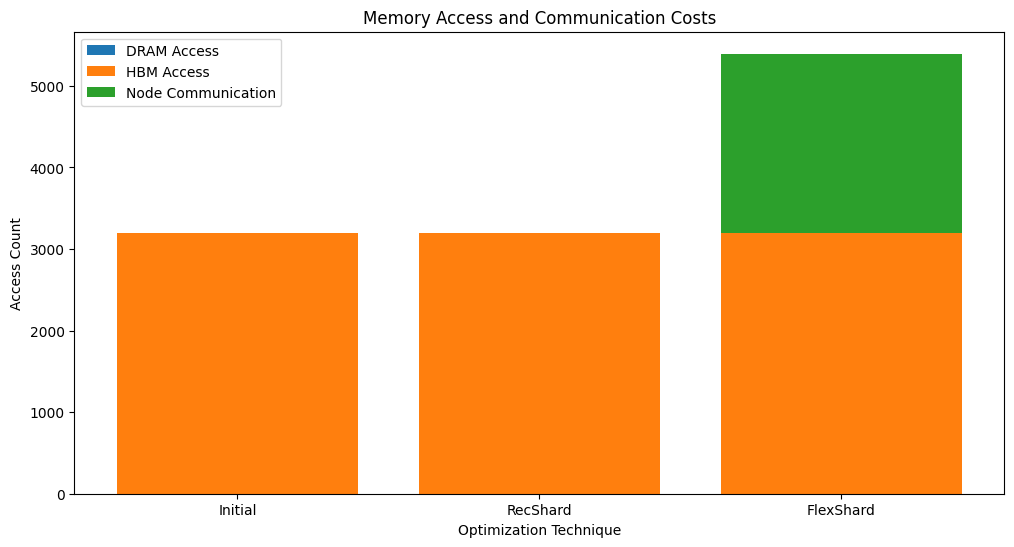

In [35]:
plt.figure(figsize=(12, 6))
plt.bar(['Initial', 'RecShard', 'FlexShard'], [dram_access, dram_access, dram_access], label='DRAM Access')
plt.bar(['Initial', 'RecShard', 'FlexShard'], [hbm_access, hbm_access, hbm_access], bottom=[dram_access, dram_access, dram_access], label='HBM Access')
plt.bar(['FlexShard'], [node_communication], bottom=[hbm_access + dram_access], label='Node Communication')
plt.xlabel('Optimization Technique')
plt.ylabel('Access Count')
plt.title('Memory Access and Communication Costs')
plt.legend()
plt.show()